## Implementation of Graph Attention Networks

Based on the following paper: <i>Graph Attention Networks</i>.

In [1]:
import numpy as np
import tensorflow as tf
import spektral
import random
import scipy
from sklearn.utils import shuffle
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input,Dense,Reshape,Activation,Flatten,Concatenate,Embedding,Dropout,LeakyReLU
from tensorflow.keras.models import Model
from sklearn.metrics import balanced_accuracy_score

import warnings
warnings.filterwarnings('ignore')

### CORA Dataset

2708 scientific publications, each represented by 1433 binary-word-count features, with 7 unique classes of papers.

In [2]:
graph = spektral.datasets.citation.Citation('cora',random_split=False,normalize_x=False)
graph = graph[0]
graph

Graph(n_nodes=2708, n_node_features=1433, n_edge_features=None, n_labels=7)

In [3]:
# a: adjacency matrix (edge weights are 1 or 0, undirected graph), x: node features, y: labels
a,x,y = graph['a'],graph['x'],graph['y']
y = np.argmax(y,axis=-1).astype("int32")
a = np.asarray(a.todense())
n_nodes = len(a)
d = np.diag(np.sum(a,axis=-1)) # degree matrix
print(a.shape,x.shape,y.shape,d.shape,n_nodes)
print(a.dtype,x.dtype,y.dtype,d.dtype)

(2708, 2708) (2708, 1433) (2708,) (2708, 2708) 2708
float32 float32 int32 float32


In [4]:
a_hat = a+np.diag(np.ones(len(a)))
neighbors = [] # nested list of neighborhood-nodes(indices) for each vertex-node
for i in range(len(a_hat)):
    neighbors.append(list(np.nonzero(a_hat[i,:])[0]))

print(len(neighbors))
print(neighbors[0:3])

2708
[[0, 633, 1862, 2582], [1, 2, 652, 654], [1, 2, 332, 1454, 1666, 1986]]


### GAT & CORA Classification

In [5]:
# creating the train,test sets - getting indices for each
indices = np.array([i for i in range(len(y))])
indices_per_class = [indices[y==i] for i in range(7)]
test_indices = np.hstack([class_i[0:50] for class_i in indices_per_class]) # equal number of all classes
train_indices = np.hstack([class_i[50:] for class_i in indices_per_class])
test_y = y[test_indices]
train_y = y[train_indices]

train_mask = np.zeros(y.shape).astype("float32") # getting loss mask so that only train data used to update params
train_mask[train_indices]=1

print(train_indices.shape,test_indices.shape,train_mask.shape)
print(train_y.shape,test_y.shape)

(2358,) (350,) (2708,)
(2358,) (350,)


In [6]:
k=4 # number of heads for attention mechanism
layer_w_1 = [[Dense(128,use_bias=False,activation=None) for _ in range(k)],[Dense(1,activation=LeakyReLU(alpha=0.2),use_bias=False) for _ in range(k)]]
layer_f_1 = Dense(128,activation='relu')

layer_w_2 = [[Dense(128,use_bias=False,activation=None) for _ in range(k)],[Dense(1,activation=LeakyReLU(alpha=0.2),use_bias=False) for _ in range(k)]]
layer_f_2 = Dense(128,activation=None)

layer_w_3 = [[Dense(128,use_bias=False,activation=None) for _ in range(k)],[Dense(1,activation=LeakyReLU(alpha=0.2),use_bias=False) for _ in range(k)]]
layer_f_3 = Dense(7,activation=None)

scc_loss = SparseCategoricalCrossentropy(from_logits=True)

In [7]:
def gat_forward(layer_in,layer_w,layer_f,neighbors,n_nodes,k):
    """ single layer forward pass of GAT
    """
    layer_att_heads = []
    
    for i in range(k):
        layer_in_k = layer_w[0][i](layer_in)
        
        node_reps = []
        for n in range(n_nodes):
            n_lis = neighbors[n] # neighbors for node n (includes node n)
            vec_emb = tf.repeat(tf.expand_dims(layer_in_k[n],axis=0),len(n_lis),axis=0)
            neigh_emb = tf.gather(layer_in_k,n_lis,batch_dims=0)
            vec_pre_e = tf.concat([vec_emb,neigh_emb],axis=-1)
            vec_e = layer_w[1][i](vec_pre_e)
            vec_a = tf.nn.softmax(tf.expand_dims(tf.squeeze(vec_e),axis=0),axis=-1)
            vec_att_rep = tf.matmul(vec_a,neigh_emb)
            node_reps.append(tf.squeeze(vec_att_rep))
        
        layer_vec_att_rep = tf.stack(node_reps)
        layer_att_heads.append(layer_vec_att_rep)

    layer_att_heads = tf.concat(layer_att_heads,axis=-1)
    layer_out = layer_f(layer_att_heads)
    return layer_out,layer_att_heads

In [11]:
optimizer=Adam(lr=0.001)
epochs=50

for epoch_i in range(epochs): # full-batch gradient descent
    losses = []
    layer_in = x
    with tf.GradientTape() as tape:
        layer_in,_ = gat_forward(layer_in,layer_w_1,layer_f_1,neighbors,n_nodes,k)
        layer_in,_ = gat_forward(layer_in,layer_w_2,layer_f_2,neighbors,n_nodes,k)
        logits,layer_in = gat_forward(layer_in,layer_w_3,layer_f_3,neighbors,n_nodes,k)
        loss = scc_loss(y,logits,sample_weight=train_mask) # only use training data
    
    trainable_variables = [] # collecting the trainable variables
    for w in [layer_f_1,layer_f_2,layer_f_3]:
        trainable_variables += w.trainable_variables
    for w_oo in [layer_w_1,layer_w_2,layer_w_3]:
        for w_o in w_oo:
            for w in w_o:
                trainable_variables += w.trainable_variables
    
    gradients = tape.gradient(loss,trainable_variables)
    optimizer.apply_gradients(zip(gradients,trainable_variables))
    losses.append(float(loss))
    
    node_predictions = np.argmax(logits.numpy(),axis=-1)
    test_pred,train_pred = node_predictions[test_indices],node_predictions[train_indices]
    train_acc = balanced_accuracy_score(train_y,train_pred)
    test_acc = balanced_accuracy_score(test_y,test_pred)
    print("epoch {}; loss:{}, train_acc:{}, test_acc:{}".format(epoch_i+1,round(sum(losses)/len(losses),4),round(train_acc,4),round(test_acc,4)))        

epoch 1; loss:1.5271, train_acc:0.1839, test_acc:0.1686
epoch 2; loss:1.372, train_acc:0.1776, test_acc:0.1743
epoch 3; loss:1.2272, train_acc:0.2276, test_acc:0.2114
epoch 4; loss:1.0764, train_acc:0.3508, test_acc:0.3286
epoch 5; loss:0.9182, train_acc:0.5143, test_acc:0.5171
epoch 6; loss:0.7787, train_acc:0.6144, test_acc:0.6143
epoch 7; loss:0.6597, train_acc:0.6589, test_acc:0.68
epoch 8; loss:0.5559, train_acc:0.7026, test_acc:0.72
epoch 9; loss:0.472, train_acc:0.745, test_acc:0.7457
epoch 10; loss:0.4069, train_acc:0.7998, test_acc:0.7971
epoch 11; loss:0.3539, train_acc:0.8459, test_acc:0.8257
epoch 12; loss:0.3141, train_acc:0.876, test_acc:0.86
epoch 13; loss:0.2887, train_acc:0.8923, test_acc:0.8857
epoch 14; loss:0.2697, train_acc:0.9034, test_acc:0.8943
epoch 15; loss:0.251, train_acc:0.9064, test_acc:0.8971
epoch 16; loss:0.2341, train_acc:0.908, test_acc:0.8914
epoch 17; loss:0.2209, train_acc:0.9088, test_acc:0.8857
epoch 18; loss:0.2101, train_acc:0.9141, test_acc:0.

### Visualization

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [13]:
tsne_emb = TSNE(n_components=2).fit_transform(layer_in.numpy())
print(tsne_emb.shape)

(2708, 2)


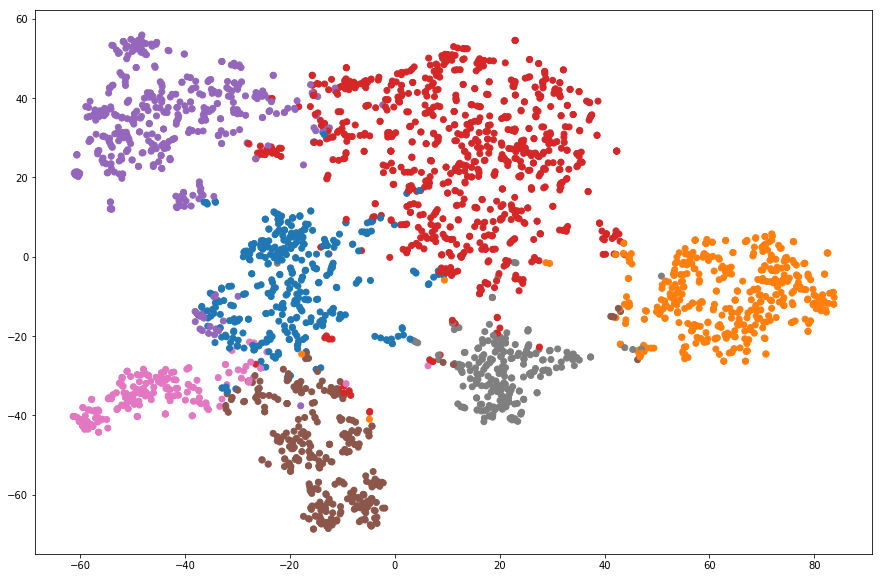

In [14]:
color_mapper = {0:'#1f77b4',1:'#7f7f7f',2:'#ff7f0e',3:'#d62728',4:'#9467bd',5:'#8c564b',6:'#e377c2'}
colors = [color_mapper[y[i]] for i in range(len(y))]

plt.figure(figsize=(15,10))
plt.scatter(tsne_emb[:,0],tsne_emb[:,1],c=colors)
plt.show()

### Alternative implementation

The use of tf.repeat is very inefficient once the number of nodes becomes large.

In [ ]:
def gat_forward(layer_in,layer_w,layer_f,att_mask,n_nodes,k):
    """ single layer forward pass of GAT
    """
    layer_att_heads = []
    for i in range(k):
        layer_in_k = layer_w[0][i](layer_in) # representation of nodes for this att-head
        layer_in_k_pre_e = tf.concat([tf.repeat(layer_in_k,n_nodes,axis=0),tf.reshape(tf.repeat(tf.expand_dims(layer_in_k,axis=0),n_nodes,axis=0),(n_nodes*n_nodes,-1))],axis=-1)
        layer_in_k_e = layer_w[1][i](layer_in_k_pre_e)
        layer_in_k_e = tf.reshape(layer_in_k_e,(n_nodes,n_nodes))
        layer_in_k_e += att_mask
        layer_in_k_a = tf.nn.softmax(layer_in_k_e,axis=-1) # attention
        layer_in_k_att_rep = tf.matmul(layer_in_k_a,layer_in_k)
        layer_att_heads.append(layer_in_k_att_rep)
    
    layer_att_heads = tf.concat(layer_att_heads,axis=-1)
    layer_out = layer_f(layer_att_heads)
    return layer_out

# att_mask is defined to be:
att_mask = a+np.diag(np.ones(len(a))) # identity allows for self-attention
att_mask[att_mask==0]=-np.inf
att_mask[att_mask==1]=0